**Character-level Seq2Seq model**

---



Install all the necessary dependencies and upload all the necessary libraries.


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import os
import string

from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.utils import plot_model 
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from google.colab import drive
from string import punctuation

Upload the dataset, which consists in an English-Italian parallel sentences. 

Furthermore, mount the personal Google Drive filesystem.

In [ ]:
!!curl -O http://www.manythings.org/anki/ita-eng.zip
!!unzip ita-eng.zip

drive.mount('/content/drive')

Mounted at /content/drive


These are global parameters which will be necessary further on.

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LSTM_NODES = 256
NUMBER_SENTENCES = 20000
NUMBER_SENTENCES_TEST = 2000

In this block, it is preprocessed all data going from the dataset downloaded previously.

In [ ]:
input_sentences = [] # All original English sentences
output_sentences = [] # All original Italian sentences with start-of-sequence and end-of-sequence tokens, respectively "\t" and "\n" (not <sos> and <eos> because we are working at character level)
input_sentences_test = [] # All original English sentences for test
output_sentences_test = [] # All original Italian sentences that will be compared with the ones predicted by the character-level NMT

input_characters = set() 
target_characters = set()

count_rows = 1
with open(os.path.join('ita.txt'), 'r', encoding='utf-8') as f: # Read the file and insert sentences in order to form a training set and a test set
    while count_rows <= (NUMBER_SENTENCES + NUMBER_SENTENCES_TEST):
        row = f.readline().rstrip().split("\t")
        if count_rows <= NUMBER_SENTENCES: # Training set
            input_sentences.append(row[0])
            # \t = start of sequence
            # \n = end of sequence
            output_sentences.append("\t" + row[1] + "\n")
        else: # Test set
            input_sentences_test.append(row[0])
            output_sentences_test.append(row[1])

        count_rows += 1

for input in input_sentences:
    for char in input:
        if char not in input_characters:
            input_characters.add(char)

for target in output_sentences:
    for char in target:
        if char not in target_characters:
            target_characters.add(char)

# Add UNK token, in order to recognize unknown chars we encountered
input_characters.add("UNK")
target_characters.add("UNK")           

input_characters = sorted(list(input_characters))
target_characters = sorted(list(target_characters))
num_encoder_tokens = len(input_characters)
num_decoder_tokens = len(target_characters)
max_encoder_seq_length = max([len(input) for input in input_sentences]) # The maximum length is computed by the character point of view (NOT WORDS!)
max_decoder_seq_length = max([len(target) for target in output_sentences]) # The maximum length is computed by the character point of view (NOT WORDS!)

input_token_index = dict([(char, index) for index, char in enumerate(input_characters)]) # Vocabulary of characters for English sentences
target_token_index = dict([(char, index) for index, char in enumerate(target_characters)]) # Vocabulary of characters for Italian sentences

Now, the training data sentences are turned into three different one-hot vectors (#1, #2, #3):
- #1 is for English sentences which will be given in input at the NMT; 
- #2 and #3 is for Italian sentences, but #2 is given at the input level of the decoder with the aim to apply *teacher forcing* to our NMT, whereas #3 is used for the evaluation model, in order to compare the predicted sentence with the real sentence (always with one-hot vectors). Remember that the real sentence does not contain the "\t" start-of-sequence: for this reason, #3 is ahead by one timestep with respect to #2.

In [ ]:
encoder_input_data = np.zeros((len(input_sentences), max_encoder_seq_length, num_encoder_tokens), dtype="float32") #1
decoder_input_data = np.zeros((len(input_sentences), max_decoder_seq_length, num_decoder_tokens), dtype="float32") #2
decoder_target_data = np.zeros((len(input_sentences), max_decoder_seq_length, num_decoder_tokens), dtype="float32") #3

for i, (input_text, target_text) in enumerate(zip(input_sentences, output_sentences)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0
    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

In [ ]:
# print("Number of samples:", len(input_sentences))
# print("Number of unique input tokens:", num_encoder_tokens)
# print("Number of unique output tokens:", num_decoder_tokens)
# print("Max sequence length for inputs:", max_encoder_seq_length)
# print("Max sequence length for outputs:", max_decoder_seq_length)
# print("Input characters:", input_characters)
# print("Target characters:", target_characters)

# print(input_token_index)
# print(target_token_index)

# print(encoder_input_data[0])
# print(decoder_input_data[0])
# print(decoder_target_data[0])

Again, turn the Italian test sentences into a one-hot vector. This one will be useful in the prediction phase.

In [ ]:
# For test
test_sentences_data = np.zeros((NUMBER_SENTENCES_TEST, max_encoder_seq_length, num_encoder_tokens), dtype='float32')

for i, test_text in enumerate(input_sentences_test):
    for t, char in enumerate(test_text):
        try:
            test_sentences_data[i, t, input_token_index[char]] = 1.0
        except: # This exception occurs if the char is not available in the Italian characters vocabulary: in this case, the UNK character is set to 1.0
            test_sentences_data[i, t, input_token_index["UNK"]] = 1.0
    decoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0

In [ ]:
# print(test_sentences_data.shape)
# print(test_sentences_data[0])

Now, we can start to build the character-level Sequence-to-Sequence model. The architecture is based on RNN and consists on two LSTM layer, the encoder and the decoder ones. The encoder takes in input the English sentence and the resulting states are passed to the decoder, responsible to translate the English sentence in the Italian one. In the decoder, however, the layers are not only influenced by the encoder states, but also by the Italian target sentence (the right translation), in oder to force teaching and reducing the error epochs by epochs. 

Pay attention: teacher forcing is applied ONLY when we are training our model, whereas in the inference model (so during the test phase) is not used, in order to evaluate the prediction kindness without supervision.

Below we can see the training model:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 69)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 77)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        333824      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

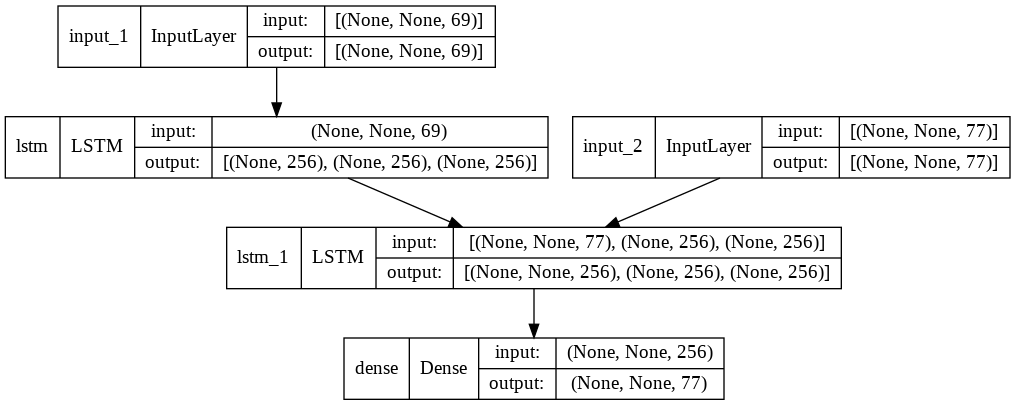

In [ ]:
# Set up the encoder
encoder_inputs = Input(shape=(None, num_encoder_tokens))
encoder = LSTM(LSTM_NODES, return_state=True)
_, state_hidden, state_cell = encoder(encoder_inputs)
encoder_states = [state_hidden, state_cell]

# Set up the decoder, using 'encoder_states' as initial state
decoder_inputs = Input(shape=(None, num_decoder_tokens))
decoder_lstm = LSTM(LSTM_NODES, return_sequences=True, return_state=True) # Return full output sequences and internal states as well
decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation="softmax")
decoder_outputs = decoder_dense(decoder_outputs)

seq2seq_model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
seq2seq_model.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])

seq2seq_model.summary()
plot_model(seq2seq_model, to_file="training_model.png", show_shapes=True, show_layer_names=True)

Train the model.

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True), # If the validation loss value does not improve within 15 epochs, stop the training
    ModelCheckpoint("/content/drive/My Drive/Colab Notebooks/Advanced_Topics_on_Computer_Science/My_Project/Character_Level_Seq2Seq_Model.h5", save_best_only=True) # Change path if you run this code in another location     
]

history = seq2seq_model.fit(
    [encoder_input_data, decoder_input_data],
    decoder_target_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_split=0.1,
    callbacks=[callbacks]
)

Epoch 1/100
282/282 [==============================] - 19s 37ms/step - loss: 1.0588 - accuracy: 0.7175 - val_loss: 0.9616 - val_accuracy: 0.7085
Epoch 2/100
282/282 [==============================] - 8s 29ms/step - loss: 0.6901 - accuracy: 0.7915 - val_loss: 0.8010 - val_accuracy: 0.7552
Epoch 3/100
282/282 [==============================] - 8s 28ms/step - loss: 0.5863 - accuracy: 0.8181 - val_loss: 0.7078 - val_accuracy: 0.7827
Epoch 4/100
282/282 [==============================] - 8s 30ms/step - loss: 0.5258 - accuracy: 0.8356 - val_loss: 0.6634 - val_accuracy: 0.7937
Epoch 5/100
282/282 [==============================] - 8s 29ms/step - loss: 0.4797 - accuracy: 0.8500 - val_loss: 0.6293 - val_accuracy: 0.8062
Epoch 6/100
282/282 [==============================] - 8s 29ms/step - loss: 0.4413 - accuracy: 0.8623 - val_loss: 0.6039 - val_accuracy: 0.8151
Epoch 7/100
282/282 [==============================] - 8s 29ms/step - loss: 0.4092 - accuracy: 0.8719 - val_loss: 0.5746 - val_accuracy

In [ ]:
# Save the model
# seq2seq_model.save("/content/drive/My Drive/Colab Notebooks/Advanced_Topics_on_Computer_Science/My_Project/Saved_Models/Character_Level_Seq2Seq_Model.h5") # Change path if you run this code in another location

In [ ]:
# Load the model
# seq2seq_model = load_model("/content/drive/My Drive/Colab Notebooks/Advanced_Topics_on_Computer_Science/My_Project/Saved_Models/Character_Level_Seq2Seq_Model.h5") # Change path if you run this code in another location

Here we can view the accuracy and the loss trend.

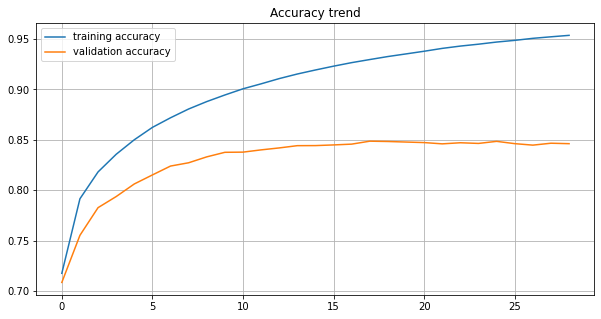

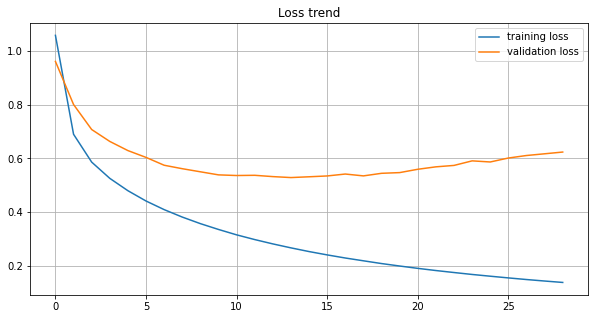

In [ ]:
def plot_accuracy(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.epoch, history.history['accuracy'], label='training accuracy')
    plt.plot(history.epoch, history.history['val_accuracy'], label='validation accuracy')
    plt.legend()
    plt.title('Accuracy trend')
    plt.grid(True)
    plt.show()

def plot_loss(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.epoch,history.history['loss'], label='training loss')
    plt.plot(history.epoch,history.history['val_loss'], label='validation loss')
    plt.legend()
    plt.title('Loss trend')
    plt.grid(True)
    plt.show()

plot_accuracy(history)
print("\n")
plot_loss(history)

The model is trained, so let's just test our sampling model.

There is a little difference with respect to the training model: here we have not the necessary to use the teacher forcing, so the model needs to be modified. Architecural speaking, the encoder remains the same (retrieving also the training model encoder states), whereas the decoder has two more input layers that corresponds to the states values generated by the current input sequence. These states values are updated at every predictions, together with the new input sequence that has to be translated.

In [ ]:
# Set up the encoder
encoder_inputs = seq2seq_model.input[0]
encoder_outputs, state_hidden_enc, state_cell_enc = seq2seq_model.layers[2].output
encoder_states = [state_hidden_enc, state_cell_enc]
encoder_model = Model(encoder_inputs, encoder_states)

# Set up the decoder
decoder_inputs = seq2seq_model.input[1]
decoder_state_input_hidden = keras.Input(shape=(LSTM_NODES,))
decoder_state_input_cell = keras.Input(shape=(LSTM_NODES,))
decoder_states_inputs = [decoder_state_input_hidden, decoder_state_input_cell]
decoder_lstm = seq2seq_model.layers[3]
decoder_outputs, state_hidden_dec, state_cell_dec = decoder_lstm(decoder_inputs, initial_state=decoder_states_inputs)
decoder_states = [state_hidden_dec, state_cell_dec]
decoder_dense = seq2seq_model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = Model([decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 69)]        0         
                                                                 
 lstm (LSTM)                 [(None, 256),             333824    
                              (None, 256),                       
                              (None, 256)]                       
                                                                 
Total params: 333,824
Trainable params: 333,824
Non-trainable params: 0
_________________________________________________________________


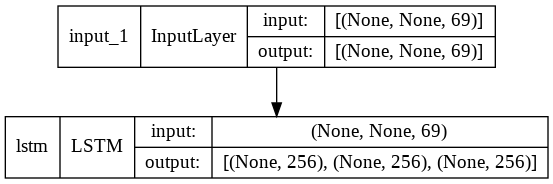

In [ ]:
encoder_model.summary()
plot_model(encoder_model, to_file="encoder_test_model.png", show_shapes=True, show_layer_names=True)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 77)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, None, 256),  342016      ['input_2[0][0]',                
                                 (None, 256),                     'input_3[0][0]',          

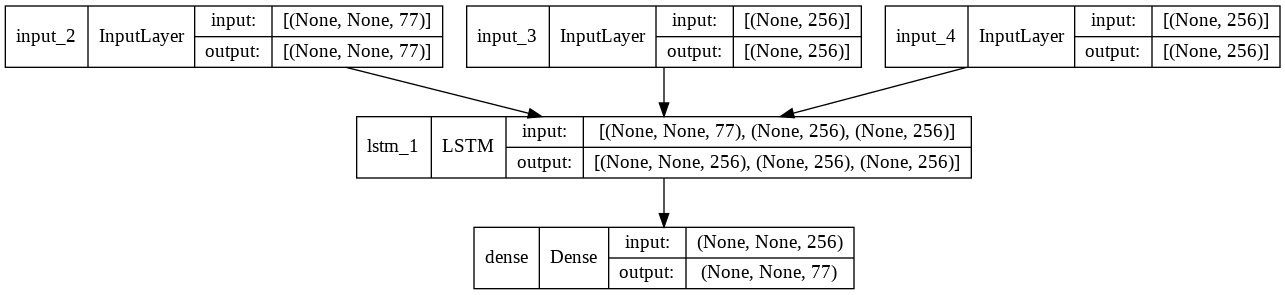

In [ ]:
decoder_model.summary()
plot_model(decoder_model, to_file="decoder_test_model.png", show_shapes=True, show_layer_names=True)

This function permits to decode an input sequence (remember that is in the form of one-hot vector) and to return the translated sentence. At the start, we predict the states values at the encoder and we fix the first target character with the start-of-sequence character. It is necessary because the model needs to understand that the sentence is about to begin and so the decoder part has to predict the first character. The prediction is made character-by-character exploiting the decoder part and updating the states values, and the prediction goes on until reaching the end-of-sequence character or the maximum output length.

In [ ]:
# Reverse-lookup token index to decode sequences back to something readable.
reverse_input_char_index = dict((index, char) for char, index in input_token_index.items())
reverse_target_char_index = dict((index, char) for char, index in target_token_index.items())

def decode_sequence(input_sequence):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_sequence)
    # Generate empty target sequence of length 1.
    target_sequence = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_sequence[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences (to simplify, here we assume a batch of size 1).
    stop_condition = False
    output_sentence = "" 
    while not stop_condition:
        output_tokens, state_hidden, state_cell = decoder_model.predict([target_sequence] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        output_sentence += sampled_char

        # Exit condition: either hit max length or find stop character.
        if sampled_char == "\n" or len(output_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_sequence = np.zeros((1, 1, num_decoder_tokens))
        target_sequence[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [state_hidden, state_cell]
    return output_sentence

Here we call the *decode_sequence* function for every English sentence reserved to the test set.

In [ ]:
input_sentences_splitted = [] # A list containing all the input sentences splitted, as requested for the BLEU computation
predicted_sentences_splitted = [] # A list containing all the translated sentences splitted, as requested for the BLEU computation

for index in range(NUMBER_SENTENCES_TEST):
    # input_sequence = encoder_input_data[index : index + 1] # To compare predicted sentence with the training sentences
    input_sequence = test_sentences_data[index : index + 1] # To compare predicted sentence with the test sentences
    predicted_sentence = decode_sequence(input_sequence)

    input_sentences_splitted.append([input_sentences_test[index].split()])
    predicted_sentences_splitted.append(predicted_sentence.split())

Print the first 500 translated sentences.

In [ ]:
predicted_sentences = [] # A list containing all the translated sentences

for index in range(len(predicted_sentences_splitted)):
    predicted_sentences.append(" ".join(predicted_sentences_splitted[index]))

for index in range(NUMBER_SENTENCES_TEST-1500):
    print("Sentence n.", index+1)
    print("-")
    print("Input sentence:", input_sentences_test[index])
    print("Target sentence:", output_sentences_test[index])
    print("Decoded sentence:", predicted_sentences[index])
    print("\n")

Sentence n. 1
-
Input sentence: I'm a pacifist.
Target sentence: Sono una pacifista.
Decoded sentence: Sono un posserosa.


Sentence n. 2
-
Input sentence: I'm a pacifist.
Target sentence: Io sono una pacifista.
Decoded sentence: Sono un posserosa.


Sentence n. 3
-
Input sentence: I'm a real man.
Target sentence: Sono un vero uomo.
Decoded sentence: Sono un poliziotto.


Sentence n. 4
-
Input sentence: I'm a real man.
Target sentence: Io sono un vero uomo.
Decoded sentence: Sono un poliziotto.


Sentence n. 5
-
Input sentence: I'm a salesman.
Target sentence: Sono un venditore.
Decoded sentence: Sono un polio ori.


Sentence n. 6
-
Input sentence: I'm a salesman.
Target sentence: Io sono un venditore.
Decoded sentence: Sono un polio ori.


Sentence n. 7
-
Input sentence: I'm a stuntman.
Target sentence: Sono uno stuntman.
Decoded sentence: Sono un politimo.


Sentence n. 8
-
Input sentence: I'm a stuntman.
Target sentence: Io sono uno stuntman.
Decoded sentence: Sono un politimo.


Se

Save and load translated sentences in order to avoid wasting time in redoing the prediction phase.

In [ ]:
# Save predictions in a file
predictions_text = open(os.path.join('Predictions_Character_Level_Seq2Seq.txt'), 'x', encoding='utf-8')
for sentence in predicted_sentences:
    predictions_text.write(str(sentence) + "\n")

# Load prediction from the file
# predicted_sentences = []
# with open(os.path.join('Predictions_Character_Level_Seq2Seq.txt'), 'r', encoding='utf-8') as f:
#     predicted_sentences.append(" ".join(f.readline().rstrip()))

Finally, compute the goodness of the translation with the most popular metric for Machine Translation, the so-called BLEU. 

This metric compares the n-grams of the target sentence (the real/reference sentence) and the predicted one. It represents in a [0, 1] value how much are the n-gram that appears both in the target sentence and the predicted one with respect to the total number of n-grams in the predicted sentence.

The idea of BLEU is that is able to compute easily and in a faster way the correspondence between a machine's output and that of a human; even more, BLEU is famous and the most used because is language independent. On the other side, BLEU does not matter about the sentence meaning and so it results to have a poor-correlation with human-judgments on sentence-level. To solve partially the problem, we use the seventh smoothing function indicated in this [paper](http://acl2014.org/acl2014/W14-33/pdf/W14-3346.pdf).

Here, we compute BLEU metric with respect to the entire corpus (so all the test sentences) with all the four variants, from 1-gram to 4-grams.

In [ ]:
def compute_bleu_score(input_sentences, predicted_sentences):
    bleu_scores = {}

    bleu_scores['1-grams'] = corpus_bleu(input_sentences, predicted_sentences, weights=(1.0, 0, 0, 0), smoothing_function=SmoothingFunction().method7)
    bleu_scores['2-grams'] = corpus_bleu(input_sentences, predicted_sentences, weights=(0.5, 0.5, 0, 0), smoothing_function=SmoothingFunction().method7)
    bleu_scores['3-grams'] = corpus_bleu(input_sentences, predicted_sentences, weights=(0.3, 0.3, 0.3, 0), smoothing_function=SmoothingFunction().method7)
    bleu_scores['4-grams'] = corpus_bleu(input_sentences, predicted_sentences, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=SmoothingFunction().method7)

    return bleu_scores

# bleu_train = bleu_score(model, tar_tokenizer, trainX, train)
bleu_scores_test = compute_bleu_score(input_sentences_splitted, predicted_sentences_splitted)

Show the BLEU results, both in strings and in a histogram.

In [ ]:
print(bleu_scores_test)

{'1-grams': 0.4044261834619575, '2-grams': 0.3152499543134069, '3-grams': 0.2975352756515143, '4-grams': 0.20635734600941777}


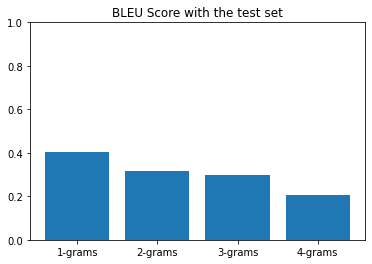

In [ ]:
plt.bar(x = bleu_scores_test.keys(), height = bleu_scores_test.values())
plt.title("BLEU Score with the test set")
plt.ylim((0,1))
plt.show()